# Summary

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [2]:
%run _imports.ipynb

Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2017-12-13 13:29:09.123457


In [3]:
%run _settings.ipynb

In [4]:
from typing import NamedTuple
import random
random.seed(42)

import h5py
from sklearn import metrics

In [5]:
import pagnn
importlib.reload(pagnn)

<module 'pagnn' from '/home/kimlab1/strokach/working/pagnn/pagnn/__init__.py'>

In [6]:
NOTEBOOK_NAME = 'train_neural_network'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()
NOTEBOOK_PATH.mkdir(exist_ok=True)

# Parameters

## Gene3D domains

In [8]:
with open(f'generate_datasets/gene3d_domains.pickle', 'rb') as fin:
    GENE3D_DOMAINS = pickle.load(fin)

## Training / validation domains

In [9]:
with open(f'generate_datasets/training_domains.pickle', 'rb') as fin:
    TRAINING_DOMAINS = pickle.load(fin)
    
with open(f'generate_datasets/validation_domains.pickle', 'rb') as fin:
    VALIDATION_DOMAINS = pickle.load(fin)
    
with open(f'generate_datasets/test_domains.pickle', 'rb') as fin:
    TEST_DOMAINS = pickle.load(fin)

## Training / validation parquet files

In [11]:
with open(f'generate_datasets/training_parquet_files.pickle', 'rb') as fin:
    TRAINING_PARQUET_FILES = pickle.load(fin)
    
with open(f'generate_datasets/validation_parquet_files.pickle', 'rb') as fin:
    VALIDATION_PARQUET_FILES = pickle.load(fin)
    
with open(f'generate_datasets/test_parquet_files.pickle', 'rb') as fin:
    TEST_PARQUET_FILES = pickle.load(fin)

# Train

In [12]:
# %% Train network

net = pagnn.network.Net()

# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()

# create your optimizer
# optimizer = optim.SGD(net.parameters(), lr=0.2, momentum=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.001)

In [33]:
# === Run ===
train_performance = []
validation_performance = []

columns = ['qseq', 'residue_idx_1_corrected', 'residue_idx_2_corrected']

idx = 0
for domain_idx, domain_folder in enumerate(tqdm.tqdm_notebook(TRAINING_DOMAINS, total=len(TRAINING_DOMAINS))):
    domain = domain_folder.partition('A%3A')[-1]
    domain_path = ADJACENCY_MATRIX_PATH.joinpath(domain_folder)
    for row_idx, row in enumerate(tqdm.tqdm_notebook(
            pagnn.iter_domain_rows(domain_path, columns=columns), leave=False, desc=f'Domain {domain_idx}')):
        row_key = f'/{domain}/{row_idx:05d}'
        try:
            dataset = pagnn.row_to_dataset(row, num_real=8, num_fake=56)
        except pagnn.SequenceTooShortError:
            print('Skipping short sequence...')
            continue
    
        # Generate tensors
        aa = np.array([pagnn.get_seq_array(seq) for seq in dataset.seqs])
        aa = Variable(torch.Tensor(aa))
        adj_expanded = Variable(torch.FloatTensor(pagnn.expand_adjacency(dataset.adj).astype(np.float32)))
        targets = Variable(torch.Tensor(dataset.targets.astype(np.float32)), requires_grad=False)

        # In the training loop
        optimizer.zero_grad()  # zero the gradient buffers
        output = net(aa, adj_expanded)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()  # Does the update

        if idx % 100 == 0:
            score = metrics.roc_auc_score(targets.data.numpy().astype(int), output.data.numpy())
            train_performance.append((idx, score))

        if idx % 1000 == 0:
            all_test_targets = []
            all_test_predictions = []
            with h5py.File(f'generate_datasets/validation-lzf.h5', 'r') as hdf5_file:
                for grp in tqdm.tqdm_notebook(
                        hdf5_file, total=len(VALIDATION_DOMAINS), leave=False, desc='Validation'):
                    for subgrp in list(hdf5_file[grp]):
                        test_seqs = hdf5_file[grp][subgrp]['seqs'][:]
                        test_adj = hdf5_file[grp][subgrp]['adj'][:]
                        test_targets = hdf5_file[grp][subgrp]['targets'][:]

                        test_aa = np.array([pagnn.get_seq_array(seq) for seq in test_seqs])
                        test_aa = Variable(torch.Tensor(test_aa), requires_grad=False)
                        test_adj_expanded = Variable(
                            torch.FloatTensor(pagnn.expand_adjacency(test_adj).astype(np.float32)),
                            requires_grad=False)
                        test_targets = Variable(torch.Tensor(test_targets.astype(np.float32)), requires_grad=False)

                        predictions = net(test_aa, test_adj_expanded)
                        
                        all_test_targets.append(test_targets.data.numpy())
                        all_test_predictions.append(predictions.data.numpy())
                        
            all_test_targets = np.hstack(all_test_targets)
            all_test_predictions = np.hstack(all_test_predictions)
            score = metrics.roc_auc_score(all_test_targets, all_test_predictions)
            test_scores.append(score)

            score = np.mean(test_scores)
            validation_performance.append((idx, score))
            print(score)
            
        idx += 1

HBox(children=(IntProgress(value=0, max=1029), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='Domain 0', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



0.841339735865


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841334171282
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841328279735


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.84132289197


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841317297847


Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue 

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841311629235


Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue 

Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841305110899
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841299194876


Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue 

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841292141838


Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue 

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841285652742
Skipping short sequence...
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841279361658


Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue 

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841273153108
Skipping short sequence...
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841266715339
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841261079651


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841255034638


Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue 

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841249230654
Skipping short sequence...
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841243151512
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.84123713951
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841230881075


Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue 

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.84122529133
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841219560292


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841213182029
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841207446756
Skipping short sequence...
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841201431604
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841195990213
Skipping short sequence...


Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue 

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841190300471
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841183990475
Skipping short sequence...
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.84117819042


Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue 

HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841172810299
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841166904732


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841161076096
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841155616105


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841149864924
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841143083969
Skipping short sequence...
Skipping short sequence...


HBox(children=(IntProgress(value=0, description='Validation', max=172), HTML(value='')))

0.841137180075



KeyboardInterrupt: 

/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


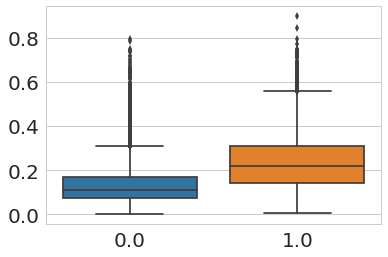

In [38]:
sns.boxplot(all_test_targets, all_test_predictions)

In [43]:
all_test_predictions

array([ 0.37617761,  0.28343776,  0.36938438, ...,  0.23349118,
        0.34759387,  0.10251146], dtype=float32)

In [37]:
plt.box(
    all_test_targets,
    all_test_predictions,
    'r.'
)

TypeError: box() takes from 0 to 1 positional arguments but 3 were given

In [31]:
validation_performance

[(100, 0.81578474799473244)]

In [66]:
%%time
lst = list(range(1000))
for _ in range(1_000_000):
    random.choice(lst)

CPU times: user 820 ms, sys: 0 ns, total: 820 ms
Wall time: 822 ms


Text(0,0.5,'ROC AUC score')

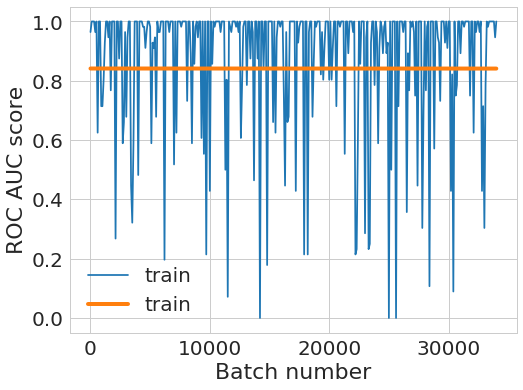

In [45]:
fg, ax = plt.subplots(figsize=(8, 6))

plt.plot(list(zip(*train_performance))[0], list(zip(*train_performance))[1], label='train')
plt.plot(list(zip(*validation_performance))[0], list(zip(*validation_performance))[1], label='train', linewidth=4)
plt.ylim = (0, 1)
plt.legend()
plt.xlabel('Batch number')
plt.ylabel('ROC AUC score')

In [ ]:
plt.plot(range(1, len(train_performance) + 1), train_performance, label='train')
plt.plot(range(1, len(validation_performance) + 1), validation_performance, label='test')
plt.ylim = (0, 1)
plt.legend()
plt.xlabel('Batch number (x100)')
plt.ylabel('ROC AUC score')